In [1]:
import os
import sys
import random
import math
import re
import time
import json

import skimage
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to weights file for our model
LAST_TRAINED_MODEL_WEIGHTS = ''

Using TensorFlow backend.


## Configurations

In [2]:
class FoodConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "food"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 8
    # Classes are:
    # 1. Background
    # 2. Samosa
    # 3. Pizza
    # 4. Cupcake
    # 5. Omelette
    # 6. Fried Rice
    # 7. Pancake
    # 8. Red Velvet Cake
    # 9. Steak

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 50

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
    EPOCHS = 50

In [3]:
config = FoodConfig()

FOOD_DIR = 'C:\College\Major Project\PROJECT\dataset2'

In [4]:
# # Override the training configurations with a few
# # changes for inferencing.
# class InferenceConfig(config.__class__):
#     # Run detection on one image at a time
#     GPU_COUNT = 1
#     IMAGES_PER_GPU = 1

# config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
EPOCHS                         50
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                21
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE     

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/dml:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Validation Dataset

In [7]:
class FoodDataset(utils.Dataset):

    def load_food(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes.
        self.add_class("food", 1, "samosa")
        self.add_class("food", 2, "pizza")
        self.add_class("food", 3, "cupcake")
        self.add_class("food", 4, "omelette")
        self.add_class("food", 5, "fried_rice")
        self.add_class("food", 6, "pancake")
        self.add_class("food", 7, "red_velvet_cake")
        self.add_class("food", 8, "steak")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance.
            # These are stores in the shape_attributes (see json format above).
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']]
                
            if type(a['regions']) is dict:
                region_attributes = [r['region_attributes'] for r in a['regions'].values()]
            else:
                region_attributes = [r['region_attributes'] for r in a['regions']]

            num_ids=[]
            for item in region_attributes:
                try:
                    if item['food'] == 'samosa':
                        num_ids.append(1)
                    elif item['food'] =='pizza':
                        num_ids.append(2)
                    elif item['food'] == 'cupcake':
                        num_ids.append(3)
                    elif item['food'] == 'omelette':
                        num_ids.append(4)
                    elif item['food'] == 'fried_rice':
                        num_ids.append(5)
                    elif item['food'] == 'pancake':
                        num_ids.append(6)
                    elif item['food'] == 'red_velvet_cake':
                        num_ids.append(7)
                    elif item['food'] == 'steak':
                        num_ids.append(8)
                except:
                    pass

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "food",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width,
                height=height,
                polygons=polygons,
                num_ids=num_ids
            )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]

        # If not a food dataset image, delegate to parent class.
        if image_info["source"] != "food":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]

        # Empty mask
        mask = np.zeros(
            [
                info["height"],
                info["width"],
                len(info["polygons"])
            ],
            dtype=np.uint8
        )

        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            x, y = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[x, y, i] = 1
    
        class_ids = image_info['num_ids']
        class_ids = np.reshape(class_ids, [mask.shape[-1]])

        # Return mask, and array of class IDs of each instance.
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "food":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [8]:
# Load validation dataset
dataset = FoodDataset()
dataset.load_food(FOOD_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 160
Classes: ['BG', 'samosa', 'pizza', 'cupcake', 'omelette', 'fried_rice', 'pancake', 'red_velvet_cake', 'steak']


## Load Model

In [9]:
# Create model in inference mode
with tf.device("/dml:0"):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [10]:
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)

model.load_weights(weights_path, by_name=True)

Loading weights  C:\College\Major Project\PROJECT\Mask_RCNN\logs\food20220612T1100\mask_rcnn_food_0050.h5






Re-starting from epoch 50


## Run Detection

In [15]:
# from skimage import io

# image_path = 'C:/College/Major Project/PROJECT/dataset/val/2155475.jpg'

# img = io.imread(image_path)

In [35]:
# # Run object detection
# results = model.detect([img])

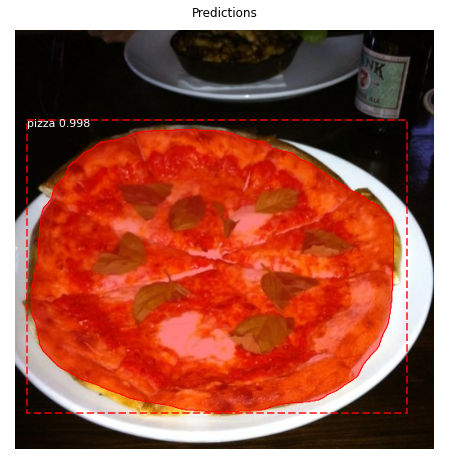

In [38]:
# # Display results
# ax = get_ax(1)
# r = results[0]

# visualize.display_instances(
#     img,
#     r['rois'],
#     r['masks'],
#     r['class_ids'],
#     dataset.class_names,
#     r['scores'],
#     ax=ax,
#     title="Predictions"
# )

# plt.savefig('Report/pred.jpg')

In [37]:
# plt.savefig('Report/pred.jpg')

<Figure size 432x288 with 0 Axes>

image ID: food.59445.jpg (85) C:\College\Major Project\PROJECT\dataset2\val\59445.jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000  int32
gt_bbox                  shape: (1, 4)                min:   34.00000  max: 1020.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  bool


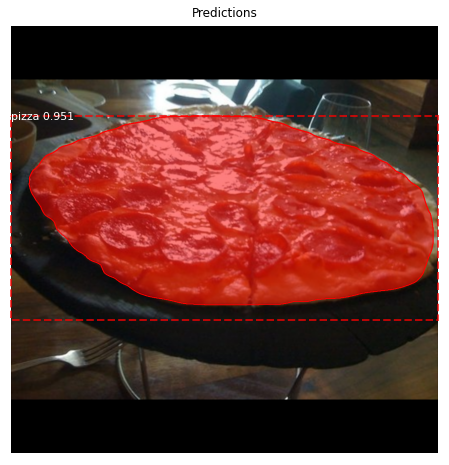

In [16]:
# Pick a random image
image_id = random.choice(dataset.image_ids)

image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)

info = dataset.image_info[image_id]

print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

visualize.display_instances(
    image,
    r['rois'],
    r['masks'],
    r['class_ids'],
    dataset.class_names,
    r['scores'],
    ax=ax,
    title="Predictions"
)

log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

### Precision-Recall

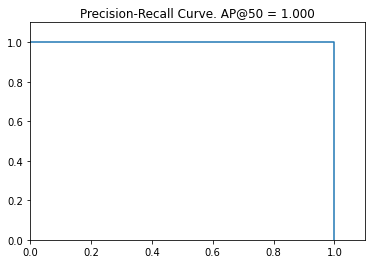

In [12]:
# Draw precision-recall curve
AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                          r['rois'], r['class_ids'], r['scores'], r['masks'])
visualize.plot_precision_recall(AP, precisions, recalls)

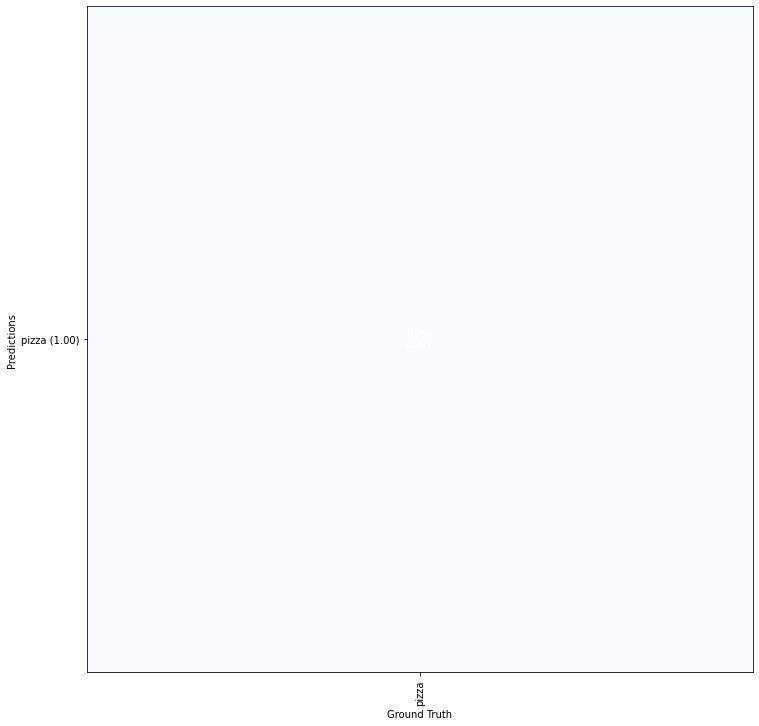

In [13]:
# Grid of ground truth objects and their predictions
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset.class_names)

### Compute mAP @ IoU=50 on Batch of Images

In [20]:
# Compute VOC-style Average Precision
def compute_batch_ap(image_ids):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'])
        APs.append(AP)
    return APs

# Pick a set of random images
image_ids = np.random.choice(dataset.image_ids, 10)
APs = compute_batch_ap(image_ids)
print("mAP @ IoU=50: ", np.mean(APs))

mAP @ IoU=50:  0.8


In [17]:
dataset.num_images

160

In [18]:
def compute_batch_ap(dataset, image_ids, verbose=1):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect_molded(image[np.newaxis], image_meta[np.newaxis], verbose=0)
        # Compute AP over range 0.5 to 0.95
        r = results[0]
        ap = utils.compute_ap_range(
            gt_bbox, gt_class_id, gt_mask,
            r['rois'], r['class_ids'], r['scores'], r['masks'],
            verbose=0)
        APs.append(ap)
        if verbose:
            info = dataset.image_info[image_id]
            meta = modellib.parse_image_meta(image_meta[np.newaxis,...])
            print("{:3} {}   AP: {:.2f}".format(
                meta["image_id"][0], meta["original_image_shape"][0], ap))
    return APs

# Run on validation set

limit = dataset.num_images

APs = compute_batch_ap(dataset, dataset.image_ids[:limit])
print("Mean AP overa {} images: {:.4f}".format(len(APs), np.mean(APs)))

  0 [384 512   3]   AP: 0.00
  1 [384 512   3]   AP: 0.00
  2 [378 512   3]   AP: 0.00
  3 [512 384   3]   AP: 0.00
  4 [384 512   3]   AP: 0.00
  5 [512 512   3]   AP: 0.00


KeyboardInterrupt: 

In [ ]:
# from skimage import io

# IMAGES_PATH = 'C:/College/Major Project/PROJECT/dataset/val'

# file_names = os.listdir(IMAGES_PATH)

# while True:
#     RANDOM_IMAGE = random.choice(file_names)
    
#     if RANDOM_IMAGE.split('.')[1] == 'jpg':
#         break

# RANDOM_IMAGE_PATH = f'{IMAGES_PATH}/{RANDOM_IMAGE}'

# print(RANDOM_IMAGE_PATH)

# image = io.imread(RANDOM_IMAGE_PATH)

# print(f'Image Shape : {image.shape}')

# plt.imshow(image)

In [ ]:
# # Run object detection
# results = model.detect([image], verbose=1)

# # Display results
# ax = get_ax(1)
# r = results[0]

# print('class ids:')
# print(r['class_ids'])

# visualize.display_instances(
#     image,
#     r['rois'],
#     r['masks'],
#     r['class_ids'],
#     dataset.class_names,
#     r['scores'],
#     ax=ax,
#     title="Predictions"
# )

In [ ]:
# mask = r['masks']
# mask = mask.astype(int)
# mask.shape

In [ ]:
# for i in range(mask.shape[2]):
#     temp = io.imread(RANDOM_IMAGE_PATH)
#     for j in range(temp.shape[2]):
#         temp[:,:,j] = temp[:,:,j] * mask[:,:,i]
#     plt.figure(figsize=(8,8))
#     plt.imshow(temp)

In [ ]:
image_id = random.choice(dataset.image_ids)

print(f'image_id : {image_id}')

image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]

print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)